In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from alienlab.improcessing import normalize
from scipy import optimize


from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func
import re
from matplotlib import image
%matplotlib widget
import alienlab.plot

p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
p.save_folder = "."
p.figsize = (10,10)
p.fontsize = 18
p.fonttick = 12

## Experimental conditions

DASA1 transferred from DMSO to acetonitrile in the morning, equilibration for several hours (experiment started at 17h)  
LED: 630nm, filter 640/20  
dichroic filter: 665 nm  
emission filter: 690/8  
MPPC detection - no filter  
excitation protocol: codes from pulse PAM  
MPPC sample_rate = 1e6 Hz  
1 pulse duration: 0.1 x 50/LED_current (LED_current between 10 and 100) units: seconds  
spacing between pulses: 200ms  
number of pulses: 250  



## Spot size calibration

distances in pixels for the calibration chart (representing 0.4mm) : 806.7329173896402 805.3620303937851
diameter estimated from distance: 0.583180046341433 mm 0.5528219274490767 mm
diameter estimated from illuminated surface: 0.5687 mm
Surface illuminated: 0.2540 mm²


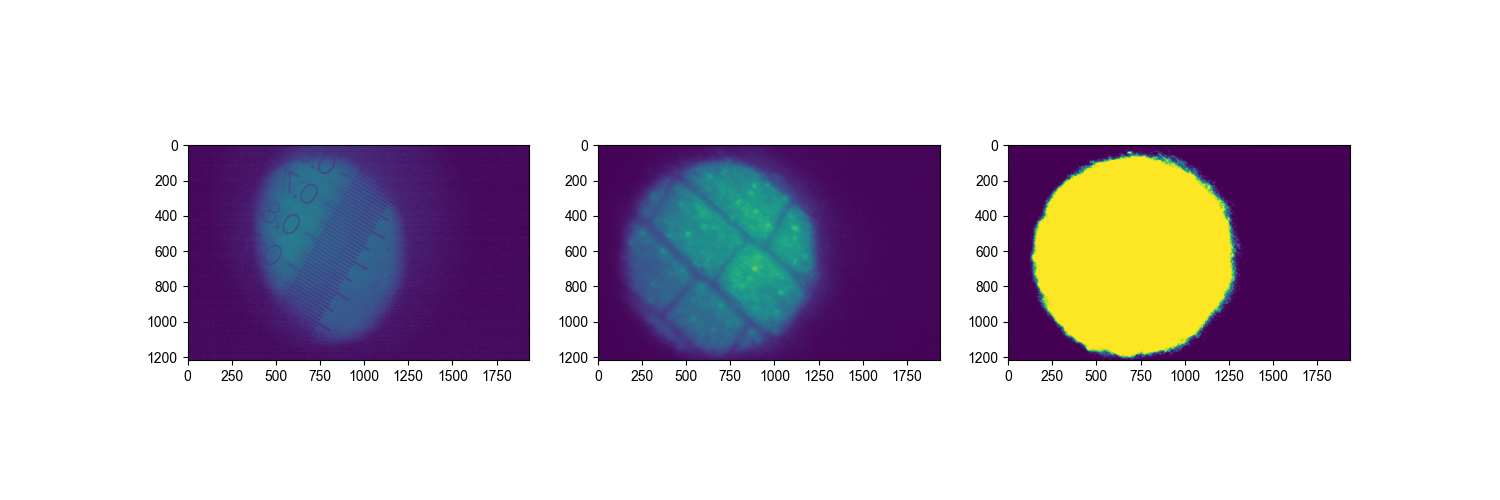

In [2]:
leaf = image.imread('feuille_exc_632_em_690.png')
mire = image.imread('mire.png')
mire[mire>0.3] = 0
fig, axs = plt.subplots(1,3, figsize=(15, 5))
axs[1].imshow(leaf/leaf.max())
axs[0].imshow(mire*10)
axs[2].imshow(leaf>0.1)

## Pixel positions

x1, x2, x3, x4 = 1150, 737, 930, 518
y1, y2, y3, y4 = 316, 1009, 190, 882

v1 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
v3 = np.sqrt((x4-x3)**2 + (y4-y3)**2)
print("distances in pixels for the calibration chart (representing 0.4mm) :", v1, v3)
ratio = 0.4*2/(v1+v3)

x1, x2, x3, x4 = 1093, 313, 236, 1126
y1, y2, y3, y4 = 189, 1068, 288, 958

d1 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
d3 = np.sqrt((x4-x3)**2 + (y4-y3)**2)

print("diameter estimated from distance:", d1*ratio, "mm", d3*ratio, "mm")
d = 2*np.sqrt(np.sum(leaf>0.1)/np.pi)*ratio
print("diameter estimated from illuminated surface: %0.4f mm"%d)
S = np.sum(leaf>0.1)*ratio**2
print("Surface illuminated: %0.4f mm²"%S)


## Calibrate light with powermeter

In [3]:
#current [mA] : power [µW] 

dict_amplitude = {
    0: 0,
    55:1.3,
    111:2.6,
    166:3.8,
    222:5.1,
    277:6.4,
    333:7.6,
    388:8.8,
    444:10,
}

S = 0.23
def dict_to_func(dict_amplitude):
    x = []
    y = []
    for k in dict_amplitude.keys():
        x.append(k)
        y.append(dict_amplitude[k])
    x = np.array(x)
    y = np.array(y)
    func = get_affine_func(x, y)
    return func
    
def amp_to_eins(dict_amplitude, amplitude):
    #ref: https://fr.wikipedia.org/wiki/Einstein_(unit%C3%A9_de_mesure)
    func = dict_to_func(dict_amplitude)
    power = func(amplitude)
    eins=power*1e-3*1e3*635/120/S
    
    return eins#*1.298/1.137



for k in dict_amplitude.keys():
    print(k, "mA corresponds to %d µeins/m²/s"%amp_to_eins(dict_amplitude, k))
print(400, "mA corresponds to %d µeins/m²/s"%amp_to_eins(dict_amplitude, 400))

0 mA corresponds to 1 µeins/m²/s
55 mA corresponds to 30 µeins/m²/s
111 mA corresponds to 59 µeins/m²/s
166 mA corresponds to 87 µeins/m²/s
222 mA corresponds to 116 µeins/m²/s
277 mA corresponds to 145 µeins/m²/s
333 mA corresponds to 174 µeins/m²/s
388 mA corresponds to 202 µeins/m²/s
444 mA corresponds to 231 µeins/m²/s
400 mA corresponds to 209 µeins/m²/s


## Fits

In [4]:

def exponential_fit(time, fluorescence):
    
    delta_time = time[-1]-time[0]
    dt = delta_time/len(time)
    
    x0 = [1e5, delta_time/5, 1]
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time, fluorescence, exp_decay))
    #logger.critical(OptimizeResult.x)
    parameters_estimated = OptimizeResult.x
    tau = parameters_estimated[1]
    
    #conditions on tau too low or too high for the second, more accurate, fit, because we will fit on a signal that lasts 5*tau
    if tau >  delta_time//10: #if too high
        tau =  delta_time//10
    if tau < 3*dt: #if too low, increase it
        tau = 5*dt
    x0 = parameters_estimated #initial guess: parameters from previous fit
    #second fit
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time[0:int(tau*5/dt)], fluorescence[0: int(tau*5/dt)], exp_decay))
    parameters_estimated = OptimizeResult.x

    
    # Estimate data based on the solution found
    y_data_predicted = exp_decay(parameters_estimated, time)
        
    return y_data_predicted, parameters_estimated




def fit_biexp(time, fluo, tau1):
    
    time = time - time[0]
    
    y_data_predicted, parameters_estimated = exponential_fit(time, fluo)
    A, tau0, y0 = parameters_estimated
    if np.abs(tau0)> 100:
        tau0 = 5
    def biexp(params, xdata):
        A0, tau0, A1, y0, delay = params
        return A0*np.exp(-(xdata-delay)/tau0)+A1*np.exp(-(xdata-delay)/tau1) + y0
    def biexp(params, xdata):
        A0, tau0, A1, y0 = params
        return A0*np.exp(-(xdata)/tau0)+A1*np.exp(-(xdata)/tau1) + y0
    
   
    x0 = [A, tau0, A, y0]
    lower_bounds = [-1e9]*len(x0)
    lower_bounds[1] = 0  

    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (lower_bounds,1e9),
                                    args = (time, fluo, biexp))        
    parameters_estimated = OptimizeResult.x
    #print("tau  biexp", parameters_estimated[1])
    ypred = biexp(parameters_estimated, time)
    #plt.plot(t+time[start], ypred)
    A0, tau0, A1, y0 = parameters_estimated
        
    if tau1<tau0:
        tau2 = tau0
        tau0 = tau1
        tau1 = tau2
        
    return ypred, parameters_estimated


In [5]:
N_exp = 5
exp_list = glob.glob("*exp*")
exp = exp_list[N_exp]
print(exp)


2022_05_04_DASA1_exp6_samepad_move_100uM


0.16520842614882833 200.000
0.172314425994513 189.000
0.1658574043425362 179.000
0.1668524627656588 169.000
0.16294137818625073 158.000
0.16792576316237282 148.000
0.1656640539705541 138.000
0.16957117471387995 128.000
0.16540413792247077 117.000
0.16630811673062457 107.000
0.1799366899534863 97.000
0.18345676034526892 87.000
0.1961319302051314 76.000
0.1994789825112201 66.000
0.26260729969752494 56.000
0.2350696962919828 46.000
0.24670612526516655 35.000
0.2536821618125666 25.000
4714097.715758541 15.000
120.03370550651515 5.000
0.2196479247774888 40.000
0.1542786911300084 30.000
0.2137039999419637 20.000
-26780.711060815884 10.000
1434040.1336865313 2.000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '1/tau')

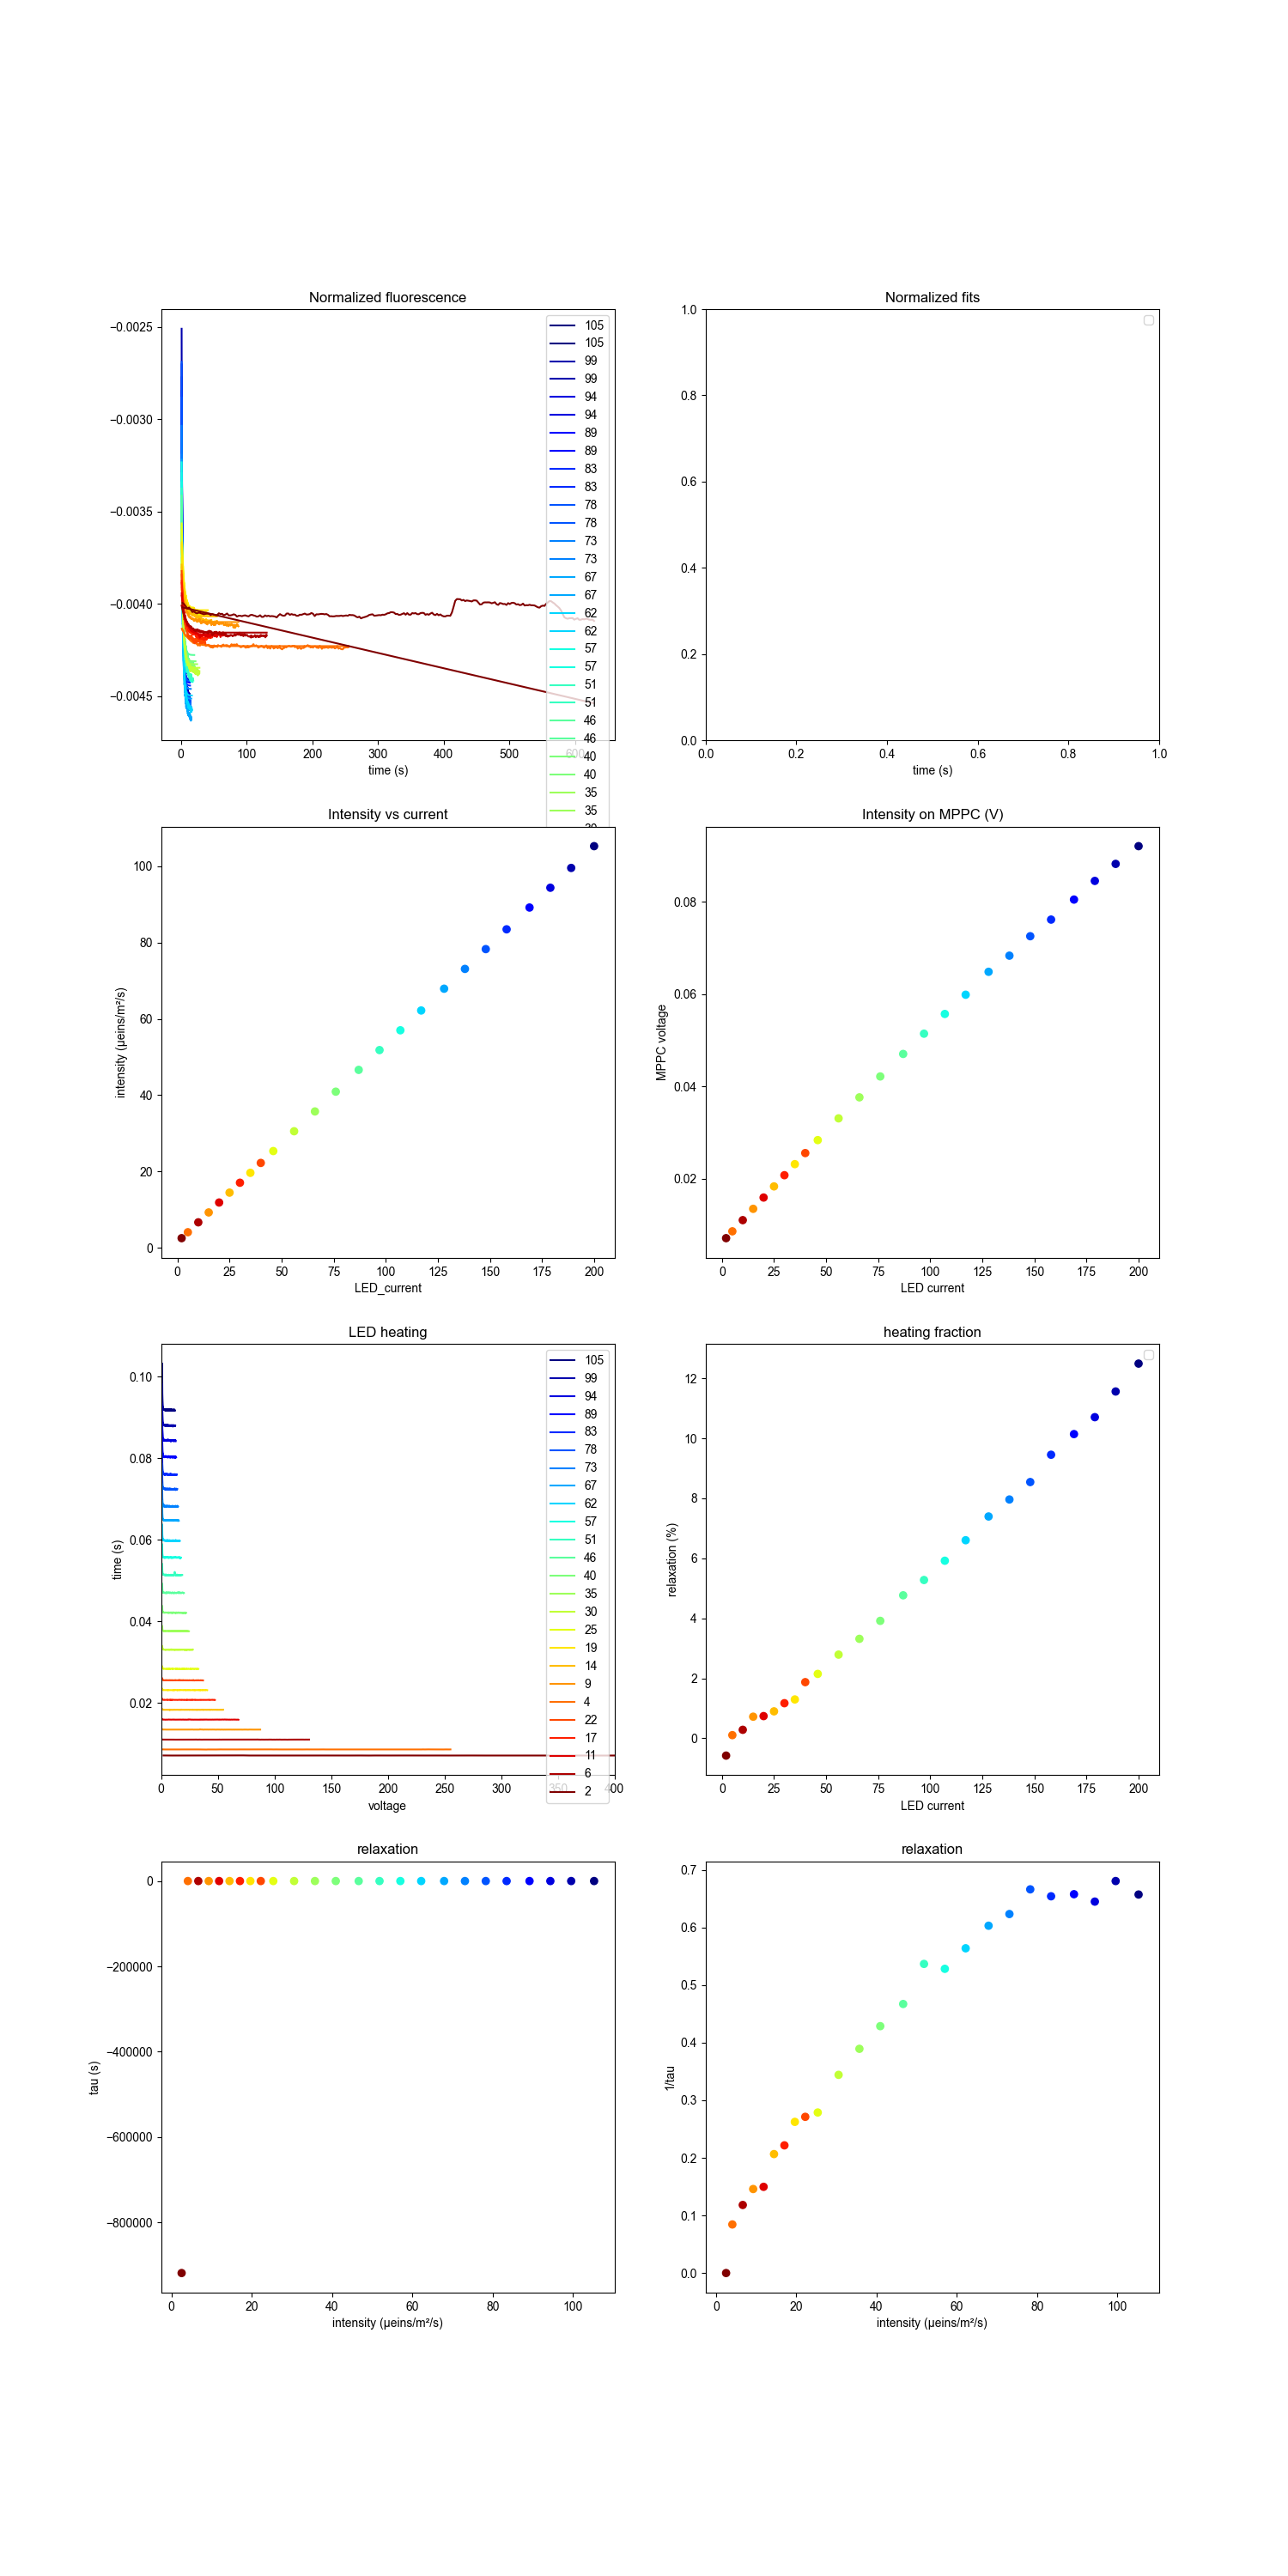

In [6]:
file_list = glob.glob(exp + "/*IBPC*")
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
axs = axs.flatten()
amplitude_list = []
intensity_list =   []
tau_list = []
color_list = []
MPPC_list  = []
heating_fraction = []

colors = plt.cm.jet(np.linspace(0,1,len(file_list)))

for N in range(0,1):

    for f, file in enumerate(file_list):
        table = glob.glob(file + "/*exponential*.csv")[0]
        df = pd.read_csv(table)

        keys = list(df.keys())
        time = np.array(df["time (s) Real Data"])
        try:
            MPPC = np.array(df["voltage (V) MPPC"])
        except:
            MPPC = time
        fluorescence = np.array(df["voltage (V) Real Data"])#/MPPC**2
        
        y_data_predicted_MPPC, parameters_estimated_MPPC =  exponential_fit(time[0:], MPPC[0:])
        
        #y_data_predicted, parameters_estimated =  fit_biexp(time[N:], fluorescence[N:], parameters_estimated_MPPC[1])
        y_data_predicted, parameters_estimated =  exponential_fit(time[N:], fluorescence[N:])
        #print(parameters_estimated[1])

        (amplitude, tau) = re.findall("\d+\.\d+",keys[3])
        print(parameters_estimated_MPPC[1], amplitude)

        tau = parameters_estimated[1]
        intensity = amp_to_eins(dict_amplitude, float(amplitude))
    
        if tau < 100:
            amplitude_list.append(float(amplitude))
            intensity_list.append(intensity)
            MPPC_list.append(np.mean(MPPC))
            heating_fraction.append((MPPC[0] - np.mean(MPPC[-10:]))/np.mean(MPPC[-10:]))
            tau_list.append(float(tau))
            color_list.append(colors[f])
        #axs[0].plot(time, normalize(fluorescence))
        #axs[0].plot(time, normalize(fluorescence/MPPC))
        if N==0:
            axs[0].plot(time[N:], y_data_predicted, label = int(intensity), color = colors[f])
            axs[0].plot(time[N:], fluorescence, label = int(intensity), color = colors[f])
            axs[4].plot(time, MPPC, label = int(intensity), color = colors[f])


amplitude_list = np.array(amplitude_list)
tau_list = np.array(tau_list)
color_list = np.array(color_list)
intensity_list = np.array(intensity_list)
heating_fraction = np.array(heating_fraction)
                        


axs[0].set_title("Normalized fluorescence")
axs[0].set_xlabel("time (s)")
axs[0].legend()
#axs[0].set_xlim(0, 400)

axs[1].set_title("Normalized fits")
axs[1].set_xlabel("time (s)")
axs[1].legend()
#axs[1].set_xlim(0, 400)

####### light intensity

axs[2].scatter(amplitude_list, intensity_list, c=color_list)

axs[2].set_title("Intensity vs current")
axs[2].set_ylabel("intensity (µeins/m²/s)")
axs[2].set_xlabel("LED_current")
                        
axs[3].scatter(amplitude_list, MPPC_list, c=color_list)

axs[3].set_title("Intensity on MPPC (V)")
axs[3].set_xlabel("LED current")
axs[3].set_ylabel("MPPC voltage")

######## LED response

                        
axs[4].set_title("LED heating")
axs[4].set_xlabel("voltage")
axs[4].set_ylabel("time (s)")
axs[4].legend()
axs[4].set_xlim(0, 400)


axs[5].scatter(amplitude_list, heating_fraction*100, c=color_list)
axs[5].set_title("heating fraction")
axs[5].set_xlabel("LED current")
axs[5].set_ylabel("relaxation (%)")
axs[5].legend()


####### relaxation
                       
                        
axs[6].scatter(intensity_list, tau_list, c=color_list)
axs[6].set_title("relaxation")
axs[6].set_xlabel("intensity (µeins/m²/s)")
axs[6].set_ylabel("tau (s)")

axs[7].scatter(intensity_list, 1/tau_list, c=color_list)
axs[7].set_title("relaxation")
axs[7].set_xlabel("intensity (µeins/m²/s)")
axs[7].set_ylabel("1/tau")


## Fit curve

## affine

Text(0, 0.5, '1/tau')

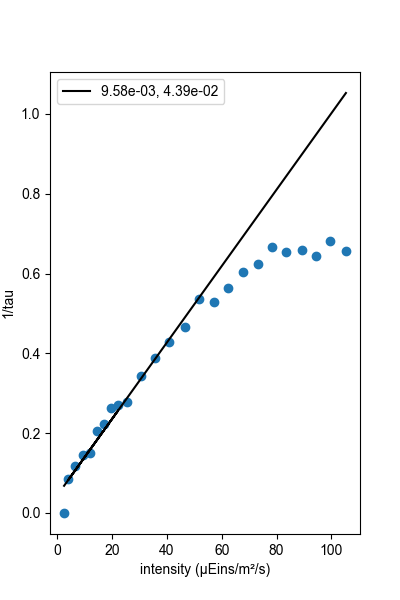

In [7]:
plt.figure(figsize = (4, 6))
Yreg, a, b, results = regression_affine(intensity_list[10:], 1/tau_list[10:] )
plt.scatter(intensity_list, 1/tau_list)
plt.plot(intensity_list, a*intensity_list + b, color = "k", label = "%0.2e, %0.2e"%(a,b))
plt.legend()
plt.xlabel('intensity (µEins/m²/s)')
plt.ylabel('1/tau')

## linear

Text(0, 0.5, '1/tau')

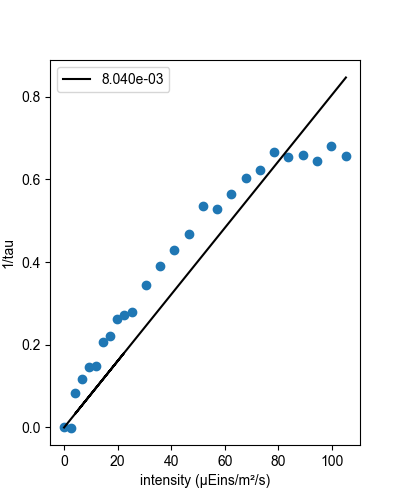

In [8]:
plt.figure(figsize = (4, 5))

D = 0
intensities  = np.append(intensity_list, 0)[D:]
taus = np.append(1/tau_list, 0)[D:]

Yreg, a, results = regression_linear(intensities, taus )
plt.scatter(intensities, taus)
plt.plot(intensities, a*intensities, color = "k", label = "%0.3e"%(a))
plt.legend()
plt.xlabel('intensity (µEins/m²/s)')
plt.ylabel('1/tau')



In [11]:

all_curves_int= {}
all_curves_tau = {}


all_curves_int[N_exp] = intensities
all_curves_tau[N_exp] = taus

KeyError: 2

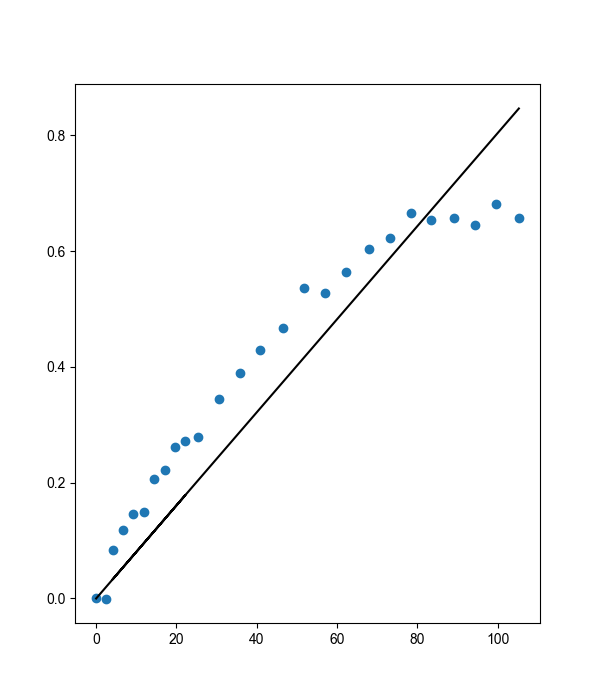

In [12]:
plt.figure(figsize = (6, 7))
regression = {}
for j, i in enumerate([5, 2, 6]):
    intensities, taus = all_curves_int[i], all_curves_tau[i]
    Yreg, a, results = regression_linear(intensities, taus )
    regression[i] = Yreg
    plt.plot(intensities, a*intensities, color = "k", label = "%0.2e"%(a))
    
    
    plt.scatter(intensities, taus, label = ["100µM", "40µM", "40µM bis"][j])
    
plt.legend()



p.majorFormatterx = "%0.1e"
p.majorFormattery = "%0.1e"
p.xlabel = 'intensity (µEins/m²/s)'
p.ylabel = '1/tau'
p.marker_list = ["o", "o",  "o", "", "", ""]
p.linestyle_list = ["", "","", "-",  "-", "-"]
p.label_list = ["100µM", "40µM",  "40µM bis" ,"100µM fit", "40µM fit",  "40µM bis fit"]
x = [all_curves_int[2], all_curves_int[5], all_curves_int[6], all_curves_int[2],  all_curves_int[5], all_curves_int[6]]
y = [all_curves_tau[2], all_curves_tau[5], all_curves_tau[6], regression[2], regression[5], regression[6]]
fig = p.plotting(x, y)
p.save_name = "DASA fits"

p.saving(fig)

In [ ]:
df = pd.DataFrame()
df["intensity (µEins/m²/s)"] = 